In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ci6ie6qi
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ci6ie6qi
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65177 sha256=11cb65d19cf28a7b773668fe97af6f332a5adb0e54d11d26ae7e80114b605609
  Stored in directory: /tmp/pip-ephem-wheel-cache-7w_r0_ep/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
 os.chdir("/content/drive/My Drive/Utils")

In [6]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
from models.NewModel import newModel
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam
from lr_finder import LRFinder
from lr_accuracy import LRAccuracy

  pip install torch-lr-finder -v --global-option="amp"


### Create model and display summary

In [7]:

model_obj = newModel()

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### Get data set object

In [0]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [0]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A
import cv2

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.PadIfNeeded(min_height=40, min_width=40),
                            A.RandomCrop(32,32),
                            A.HorizontalFlip(p=0.7),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [10]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [11]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=512)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

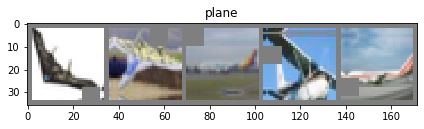

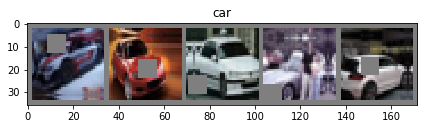

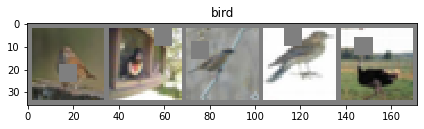

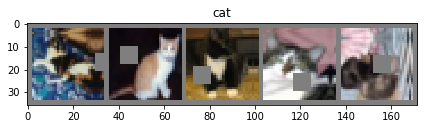

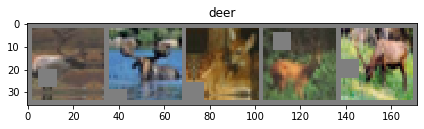

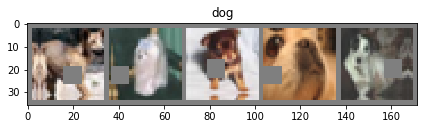

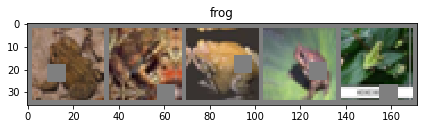

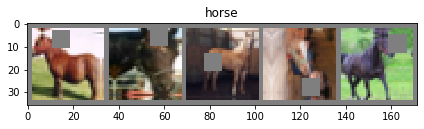

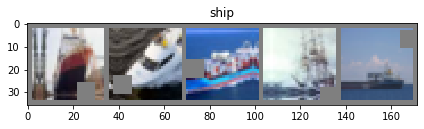

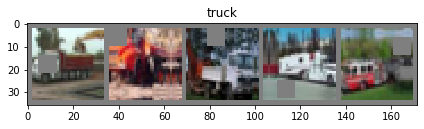

In [12]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Find LR

epoch = 3 LR=0.0048 Batch_id=97 Accuracy=62.60: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
epoch = 4 LR=0.006699999999999999 Batch_id=97 Accuracy=68.28: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
epoch = 6 LR=0.0105 Batch_id=97 Accuracy=75.97: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
epoch = 7 LR=0.012400000000000001 Batch_id=97 Accuracy=78.30: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
epoch = 8 LR=0.014300000000000002 Batch_id=97 Accuracy=79.94: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
epoch = 9 LR=0.016200000000000003 Batch_id=97 Accuracy=82.21: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
epoch = 10 LR=0.0181 Batch_id=97 Accuracy=82.70: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Best Accuracy 82.696
Best Lr 0.0181


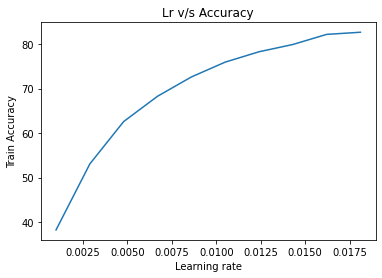

In [13]:

criterion = nn.CrossEntropyLoss()
# optimizer = helper_obj.get_l2_regularizer(weight_decay=0.0001, lr=1e-5, momentum=0.9) #SGD with l2 regulizer
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=500, step_mode="exp")
# lr_finder.plot()
# training_lr = lr_finder.get_best_lr()
# lr_finder.reset()
lr_acc_obj = LRAccuracy()
lr_acc_obj.reset_data()
lr_acc_obj.range_test(epochs = 10, model = model, device=device, train_loader = train_loader, criterion = criterion)
best_lr = lr_acc_obj.get_best_lr()
lr_acc_obj.plot_acc_lr()
lr_acc_obj.reset_data()

### Run the model

In [14]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR


optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9,weight_decay=0.005 ) 
scheduler = OneCycleLR(optimizer, max_lr = best_lr, total_steps=None, epochs=24, steps_per_epoch=len(train_loader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.9, max_momentum=0.95, div_factor=10,final_div_factor =1)
EPOCHS = 25


train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()
requires_misclassified = False

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    
    train_obj.train(model, device, train_loader, optimizer, criterion,scheduler = scheduler)
    if epoch == (EPOCHS - 1):
      requires_misclassified = True 
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=requires_misclassified)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: 0.0018100000000000002


Train Set: Train Loss=0.31148824095726013 Batch_id=97 Accuracy=88.59: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8669/10000 (86.69%)

EPOCH: 2
LR: 0.005884745267800625


Train Set: Train Loss=0.3757484555244446 Batch_id=97 Accuracy=89.38: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8586/10000 (85.86%)

EPOCH: 3
LR: 0.00995949053560125


Train Set: Train Loss=0.3994189202785492 Batch_id=97 Accuracy=88.66: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8478/10000 (84.78%)

EPOCH: 4
LR: 0.014034235803401877


Train Set: Train Loss=0.3396090567111969 Batch_id=97 Accuracy=87.90: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8083/10000 (80.83%)

EPOCH: 5
LR: 0.01809820405713306


Train Set: Train Loss=0.3775433301925659 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8396/10000 (83.96%)

EPOCH: 6
LR: 0.01728337812676091


Train Set: Train Loss=0.32305505871772766 Batch_id=97 Accuracy=88.77: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8591/10000 (85.91%)

EPOCH: 7
LR: 0.01646855219638876


Train Set: Train Loss=0.4273684024810791 Batch_id=97 Accuracy=89.40: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8666/10000 (86.66%)

EPOCH: 8
LR: 0.01565372626601661


Train Set: Train Loss=0.20364859700202942 Batch_id=97 Accuracy=90.91: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8600/10000 (86.00%)

EPOCH: 9
LR: 0.014838900335644462


Train Set: Train Loss=0.2713884115219116 Batch_id=97 Accuracy=91.81: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8849/10000 (88.49%)

EPOCH: 10
LR: 0.014024074405272315


Train Set: Train Loss=0.26162463426589966 Batch_id=97 Accuracy=92.45: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8845/10000 (88.45%)

EPOCH: 11
LR: 0.013209248474900166


Train Set: Train Loss=0.28764691948890686 Batch_id=97 Accuracy=92.77: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8852/10000 (88.52%)

EPOCH: 12
LR: 0.012394422544528017


Train Set: Train Loss=0.19938842952251434 Batch_id=97 Accuracy=93.75: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8900/10000 (89.00%)

EPOCH: 13
LR: 0.011579596614155868


Train Set: Train Loss=0.16873066127300262 Batch_id=97 Accuracy=93.95: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8712/10000 (87.12%)

EPOCH: 14
LR: 0.010764770683783719


Train Set: Train Loss=0.2111513912677765 Batch_id=97 Accuracy=94.63: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8928/10000 (89.28%)

EPOCH: 15
LR: 0.00994994475341157


Train Set: Train Loss=0.13713638484477997 Batch_id=97 Accuracy=95.07: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8982/10000 (89.82%)

EPOCH: 16
LR: 0.00913511882303942


Train Set: Train Loss=0.11254612356424332 Batch_id=97 Accuracy=95.74: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9029/10000 (90.29%)

EPOCH: 17
LR: 0.008320292892667272


Train Set: Train Loss=0.14935992658138275 Batch_id=97 Accuracy=96.30: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9036/10000 (90.36%)

EPOCH: 18
LR: 0.007505466962295123


Train Set: Train Loss=0.09811628609895706 Batch_id=97 Accuracy=96.44: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9038/10000 (90.38%)

EPOCH: 19
LR: 0.006690641031922974


Train Set: Train Loss=0.10128465294837952 Batch_id=97 Accuracy=96.93: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9216/10000 (92.16%)

EPOCH: 20
LR: 0.005875815101550823


Train Set: Train Loss=0.07250981777906418 Batch_id=97 Accuracy=97.46: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9221/10000 (92.21%)

EPOCH: 21
LR: 0.005060989171178674


Train Set: Train Loss=0.07117670029401779 Batch_id=97 Accuracy=97.73: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9260/10000 (92.60%)

EPOCH: 22
LR: 0.0042461632408065265


Train Set: Train Loss=0.0670904666185379 Batch_id=97 Accuracy=98.17: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9290/10000 (92.90%)

EPOCH: 23
LR: 0.0034313373104343774


Train Set: Train Loss=0.06330006569623947 Batch_id=97 Accuracy=98.45: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9275/10000 (92.75%)

EPOCH: 24
LR: 0.0026165113800622284


Train Set: Train Loss=0.04463440552353859 Batch_id=97 Accuracy=98.68: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]



Test set: Average loss: 0.0004, Accuracy: 9334/10000 (93.34%)

Maximum Training Accuracy =  98.68
Maximum Testing Accuracy =  93.34


### Display graphs

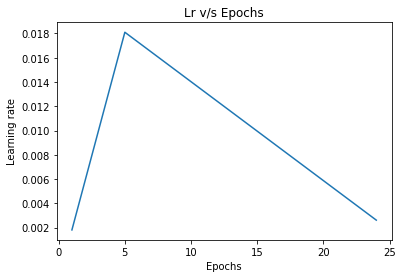

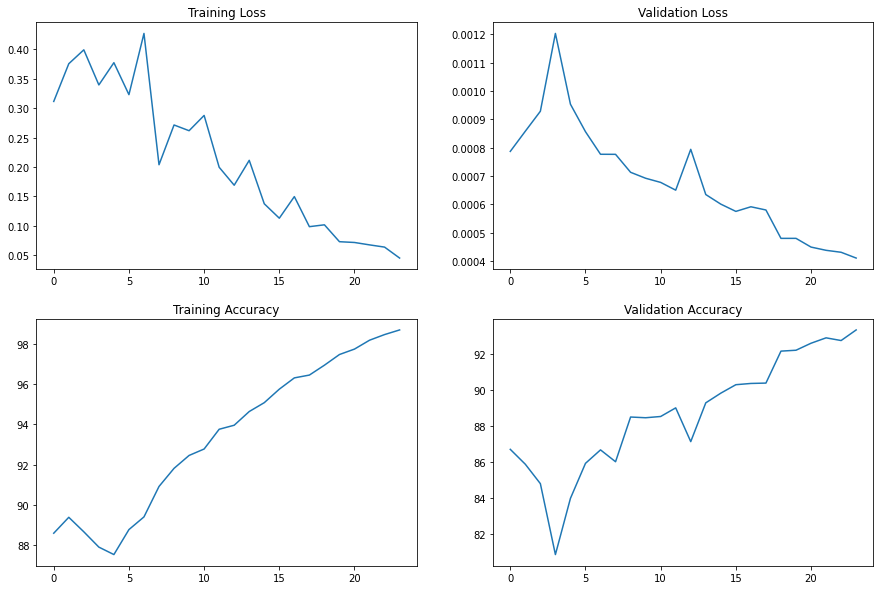

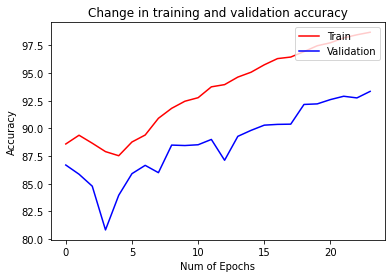

In [15]:
train_obj.plot_cycle_lr()
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_graph()


###Display 25 misclassified images

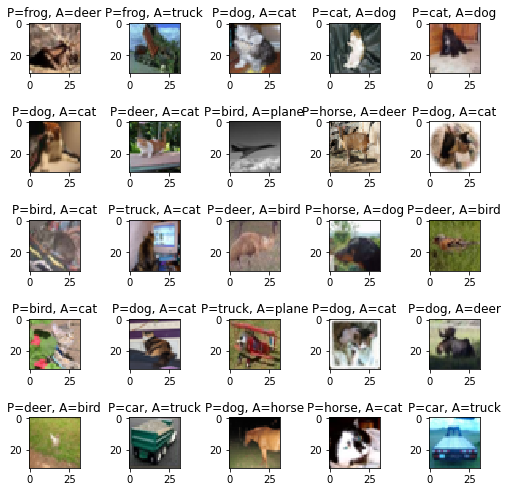

In [16]:
plt_obj.plot_cifar_misclassified(misclassified_images)

###Visualizing Gradcam results for 25 misclassified images in all layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


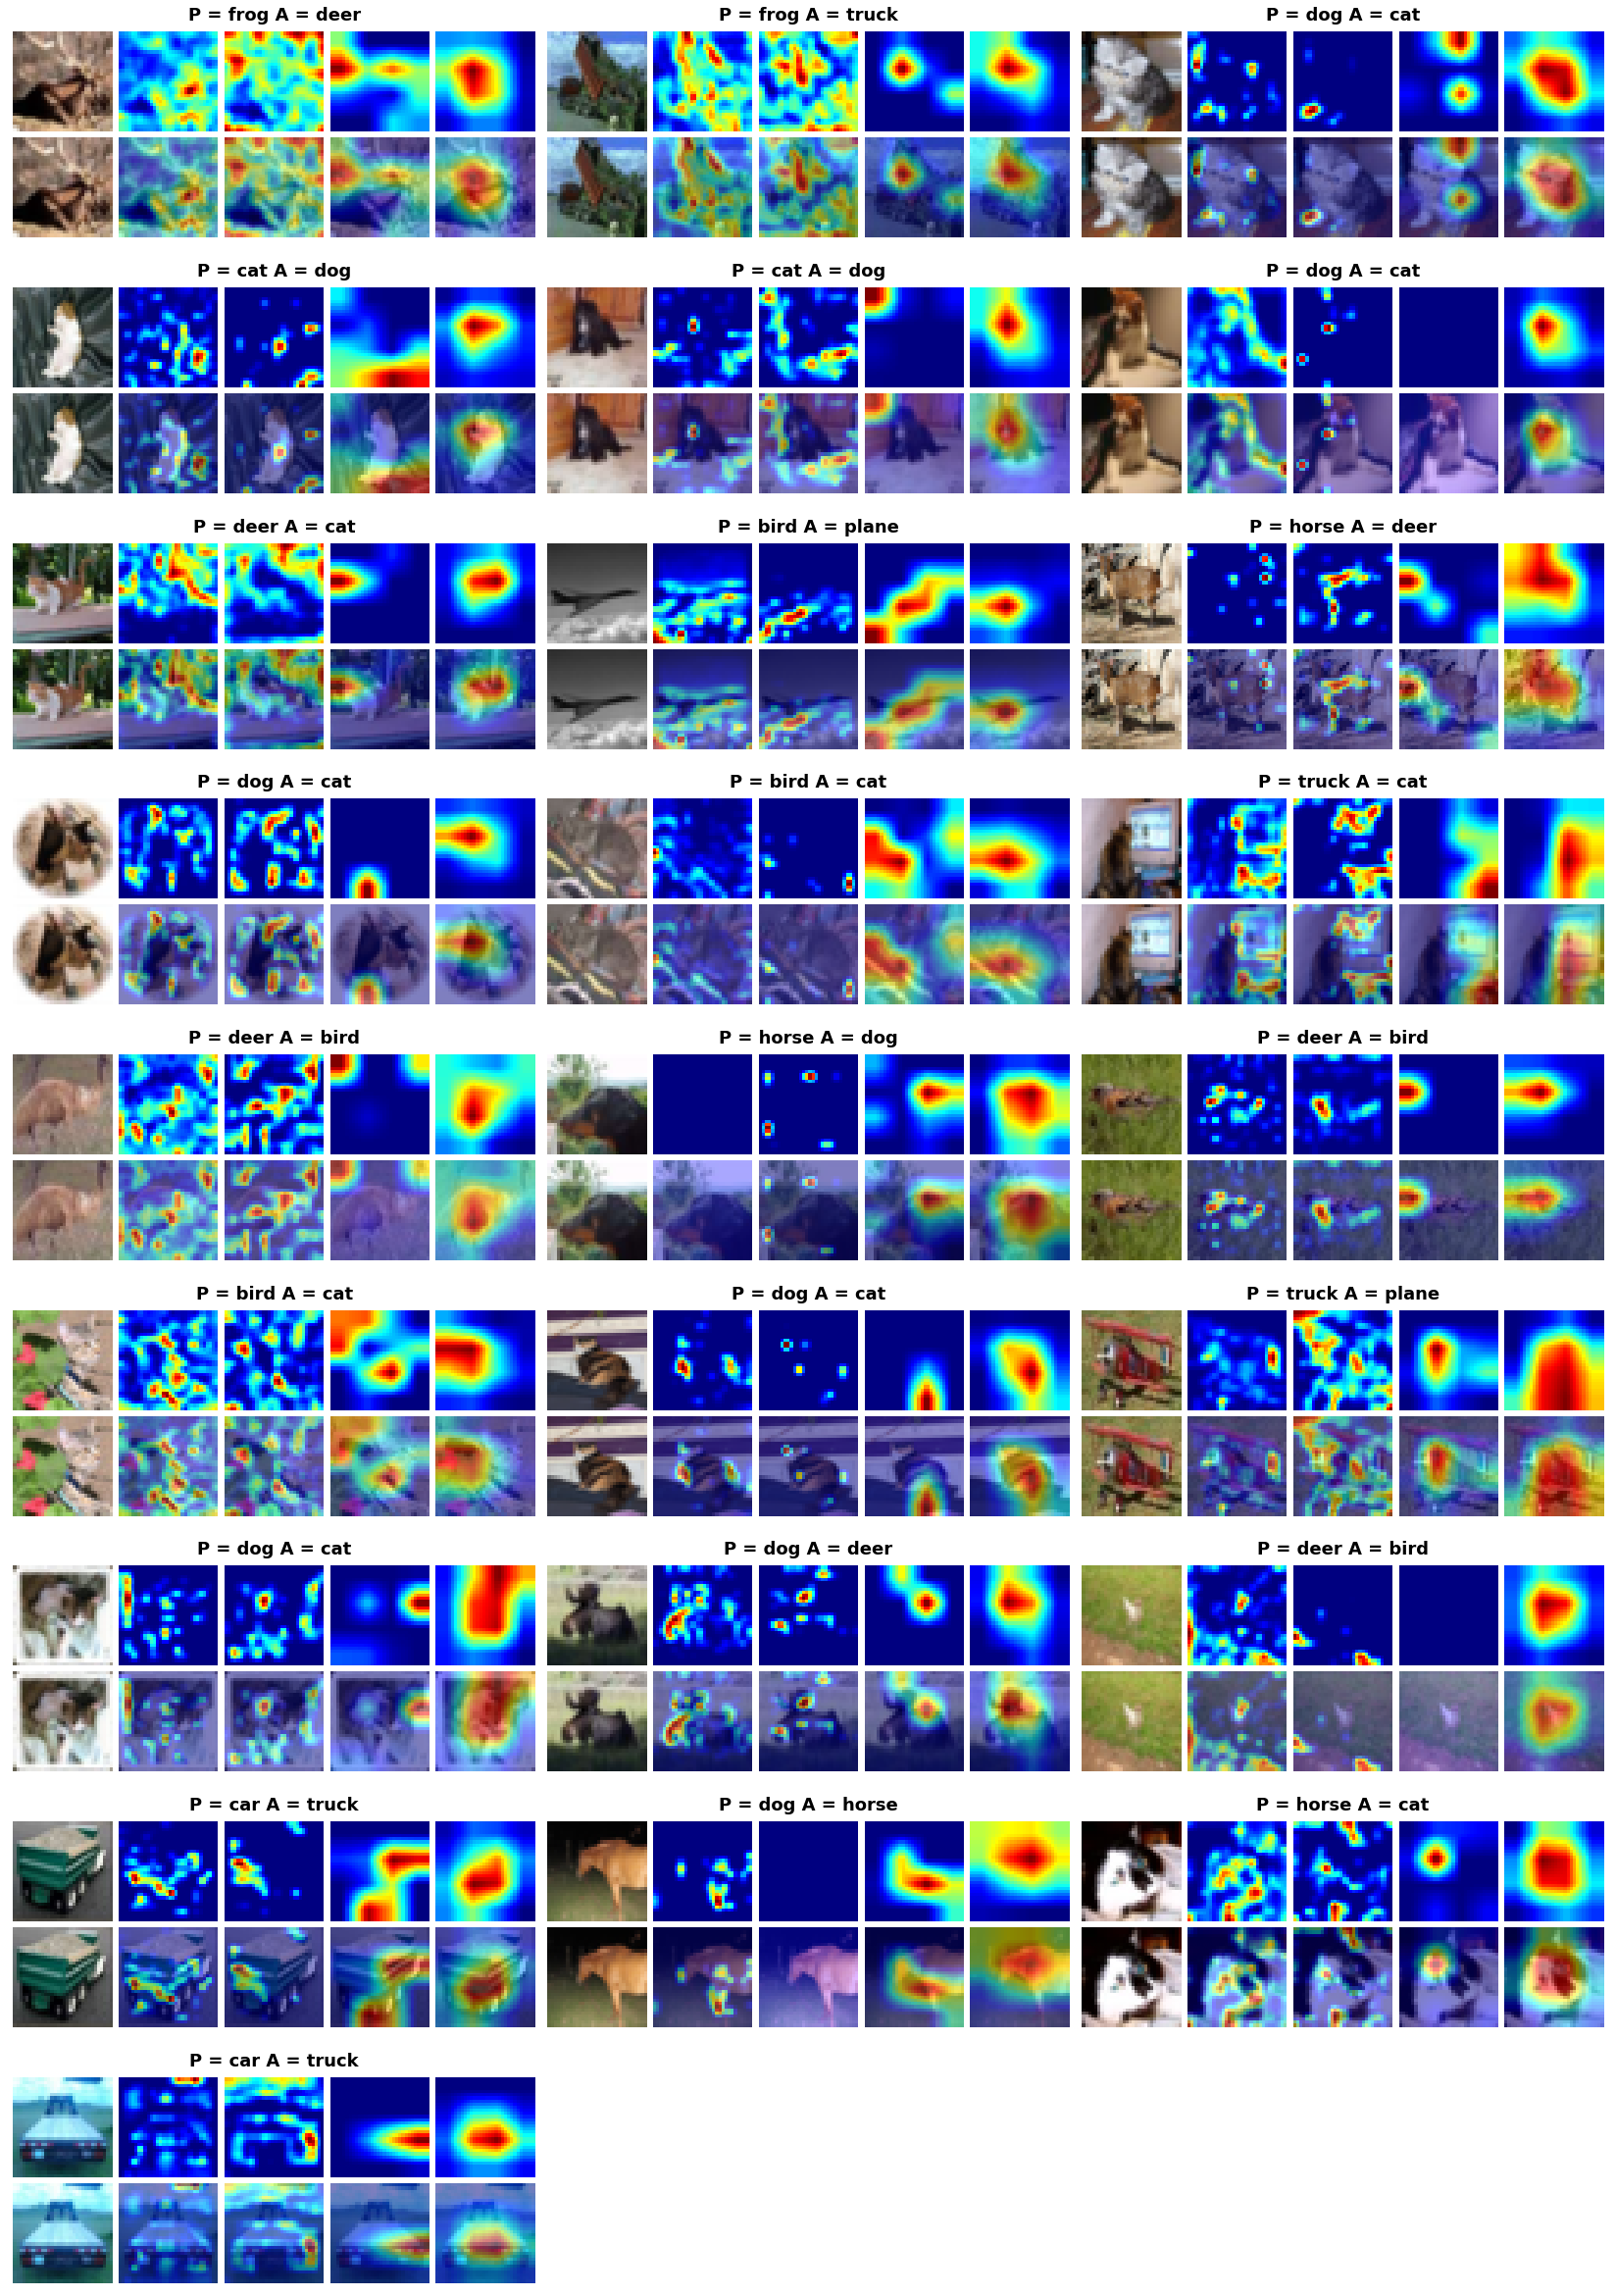

In [17]:
layers = [model.layer1, model.R1, model.layer3, model.R2]
helper_obj.get_gradcam_images(model,layers,misclassified_images,classes)